In [331]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(rc={'figure.figsize':(11.7,8.27)})
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go
from scipy import stats


# Data exploration
First we will explore the data for insights

## Application table

In [332]:
application_train = pd.read_csv('./datasets/application_train.csv')

In [333]:
application_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE              object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                   

In [334]:
pd.options.display.max_columns = None
application_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

We can see that we have a lot of columns. This means that there is a possible dimensionality reduction to be done here.
We can also observe that we have a some missing data. We should look and see how many missing values we have and how we should deal with them.
Finally, we can see that we have a lot of categorical features. We should analyse them in order to come up with a proper encoding. 

### Data balance

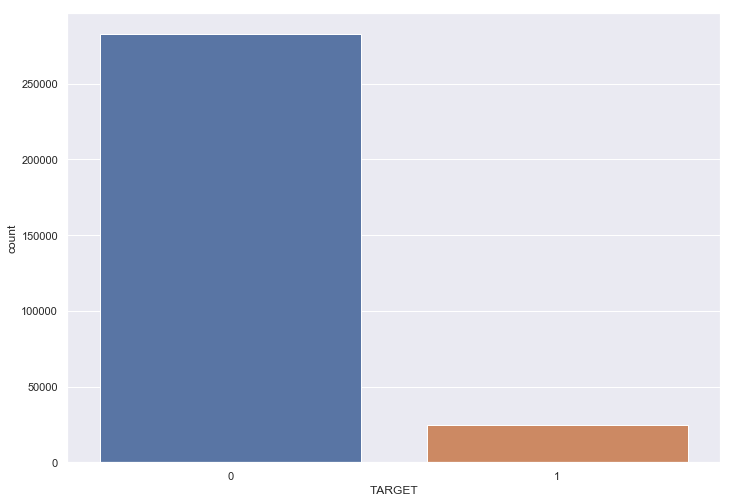

In [335]:
sns.countplot(x="TARGET", data=application_train)

We can see that our data is highly skewed! (most applicants didn't have any payment difficulties)

### Missing values

In [336]:
def list_missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = ((total/df.SK_ID_CURR.count())*100).sort_values(ascending = False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'], sort=True)
    missing_data = missing_data[(missing_data['%'] > 0)]
    return missing_data.sort_values(by='%', ascending=False)

missing_data_list = list_missing_data(application_train)
missing_data_list.head(20)

,Total,%
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


For now, we will drop the column with more than 40% missing values, and the rest will be grouped in a bin (we will bin the values of the column and add a seperate bin for NaN values)

In [337]:
columns_to_drop = missing_data_list[missing_data_list['%']>40].index.tolist()
application_train.drop(columns=columns_to_drop,axis = 1, inplace = True)

In [338]:
application_train.info() # down to 73 features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 73 columns):
SK_ID_CURR                     307511 non-null int64
TARGET                         307511 non-null int64
NAME_CONTRACT_TYPE             307511 non-null object
CODE_GENDER                    307511 non-null object
FLAG_OWN_CAR                   307511 non-null object
FLAG_OWN_REALTY                307511 non-null object
CNT_CHILDREN                   307511 non-null int64
AMT_INCOME_TOTAL               307511 non-null float64
AMT_CREDIT                     307511 non-null float64
AMT_ANNUITY                    307499 non-null float64
AMT_GOODS_PRICE                307233 non-null float64
NAME_TYPE_SUITE                306219 non-null object
NAME_INCOME_TYPE               307511 non-null object
NAME_EDUCATION_TYPE            307511 non-null object
NAME_FAMILY_STATUS             307511 non-null object
NAME_HOUSING_TYPE              307511 non-null object
REGION_POPULATION_RELATI

### Outliers
We will now see if there are any outliers in the data (extreme/weird values..) 

#### CODE_GENDER

In [339]:
application_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

We have a 4 rows with the CODE_GENDER value 'XNA', we will replace them.

In [340]:
application_train['CODE_GENDER'] = application_train.CODE_GENDER.replace('XNA', 'F')
application_train.CODE_GENDER[(application_train.CODE_GENDER == 'XNA')].count()

0

#### CNT_CHILDREN

In [341]:
application_train.CNT_CHILDREN.describe() # 19 children?! Why not ..

count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64

#### DAYS_EMPLOYED

In [342]:
(application_train.DAYS_EMPLOYED/-365).describe() 

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

Here we have a wrong value for the current emplyment duration. We will remove this value

In [343]:
application_train.DAYS_EMPLOYED[(application_train.DAYS_EMPLOYED > 36500)].count()

55374

There are a lot of rows with this value. We will replace it with NaN for now, and later, when we will bin the column, we will place them in a seperate bin.

In [344]:
application_train['DAYS_EMPLOYED'] = application_train.DAYS_EMPLOYED.replace(365243, np.NaN)
application_train.DAYS_EMPLOYED[(application_train.DAYS_EMPLOYED > 36500)].count()

0

#### OCCUPATION_TYPE

In [345]:
application_train['OCCUPATION_TYPE'].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

#### ORGANIZATION_TYPE

In [346]:
application_train['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

#### AMT_INCOME_TOTAL

In [347]:
application_train.AMT_INCOME_TOTAL.describe() 

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

We have some outliers here (people making over 1M)

In [348]:
print('Number of clients making more than 1M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 1000000)].count()))
print('Number of clients making more than 2M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 2000000)].count()))
print('Number of clients making more than 10M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 10000000)].count()))

Number of clients making more than 1M: 250
Number of clients making more than 2M: 44
Number of clients making more than 10M: 3


### Dataviz
In this part, we will visualize some data get general information about the data

#### Categorical features
First, we will deal with categorical features

##### NAME_CONTRACT_TYPE
Identification if loan is cash or revolving

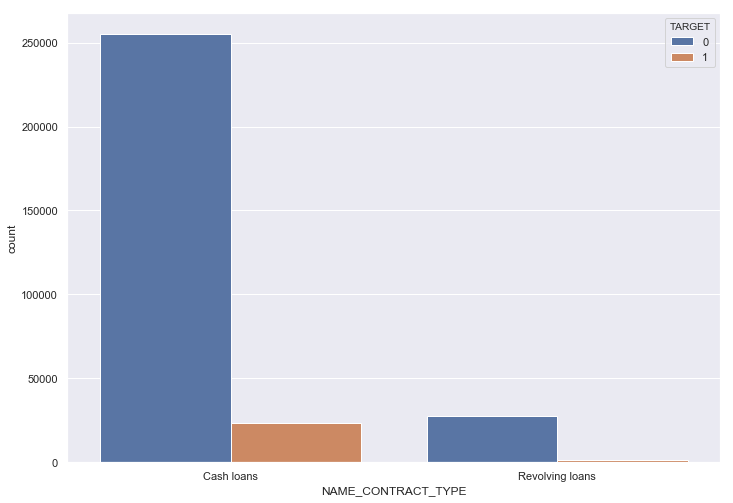

In [349]:
sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=application_train)

##### CODE_GENDER
Gender of the client

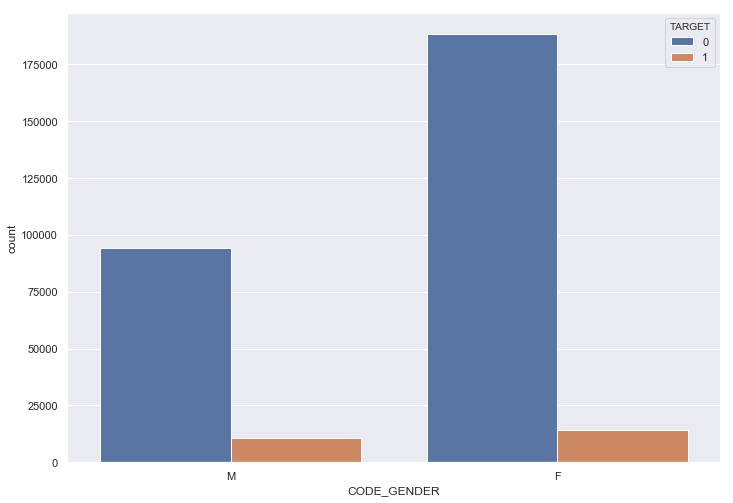

In [350]:
sns.countplot(x='CODE_GENDER', hue='TARGET', data=application_train)

##### FLAG_OWN_CAR
Flag if the client owns a car

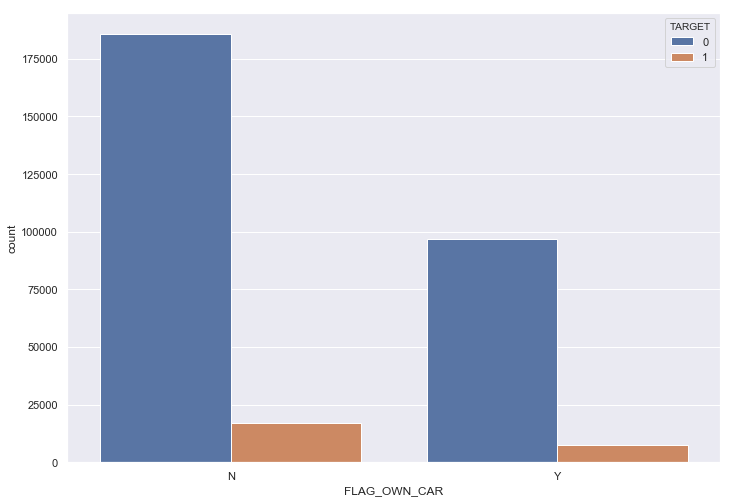

In [351]:
sns.countplot(x='FLAG_OWN_CAR', hue='TARGET', data=application_train)

##### FLAG_OWN_REALTY
Flag if client owns a house or flat

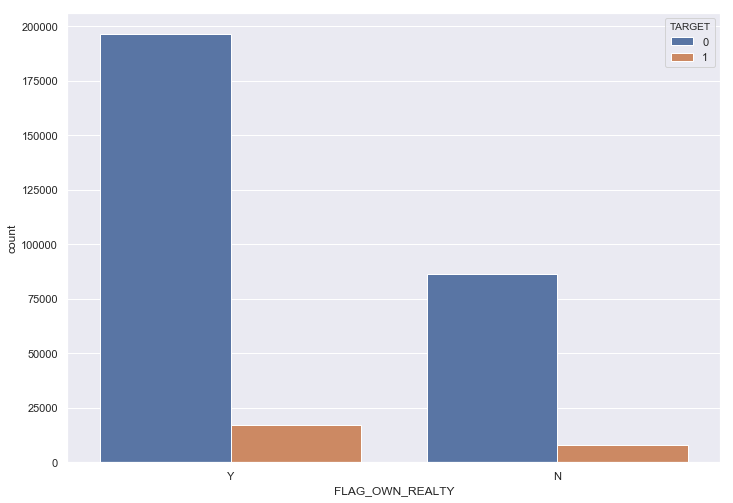

In [352]:
sns.countplot(x='FLAG_OWN_REALTY', hue='TARGET', data=application_train)

##### NAME_TYPE_SUITE
Who was accompanying client when he was applying for the loan

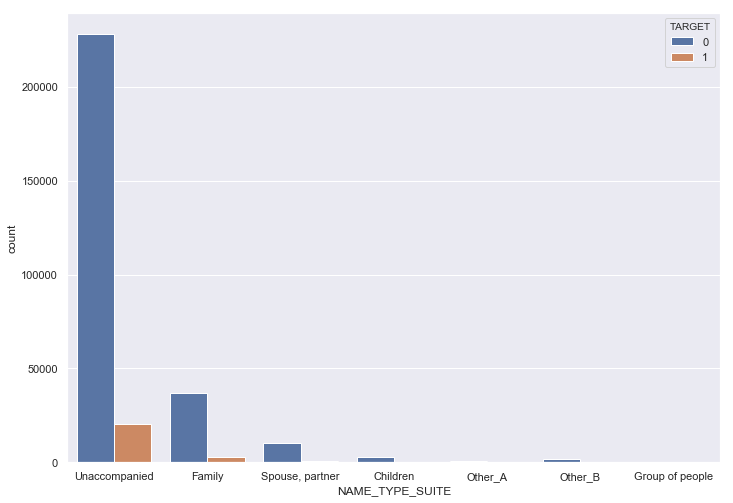

In [353]:
sns.countplot(x='NAME_TYPE_SUITE', hue='TARGET', data=application_train)

##### NAME_INCOME_TYPE
Clients income type (businessman, working, maternity leave,..)

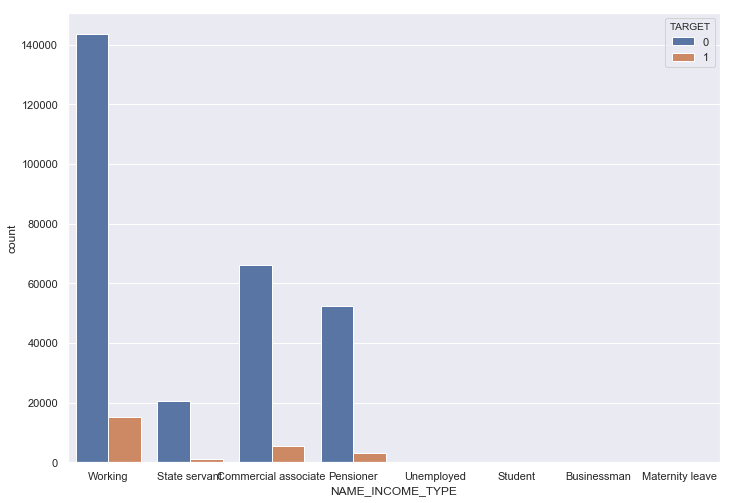

In [354]:
sns.countplot(x='NAME_INCOME_TYPE', hue='TARGET', data=application_train)

##### NAME_EDUCATION_TYPE
Level of highest education the client achieved

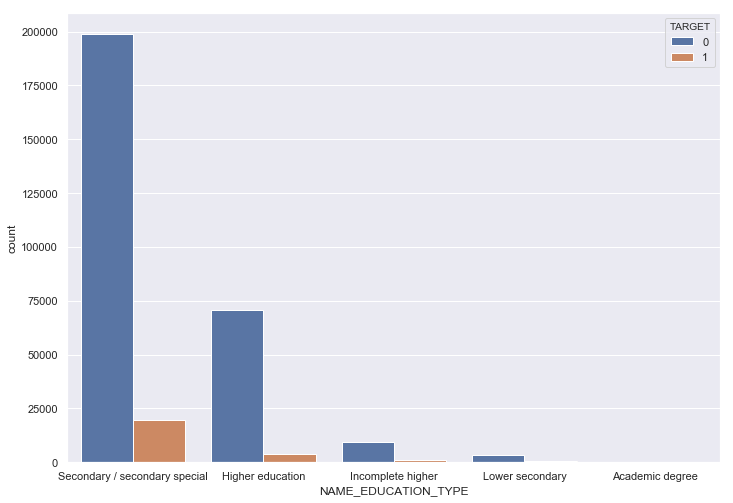

In [355]:
sns.countplot(x='NAME_EDUCATION_TYPE', hue='TARGET', data=application_train)

##### NAME_FAMILY_STATUS
Family status of the client

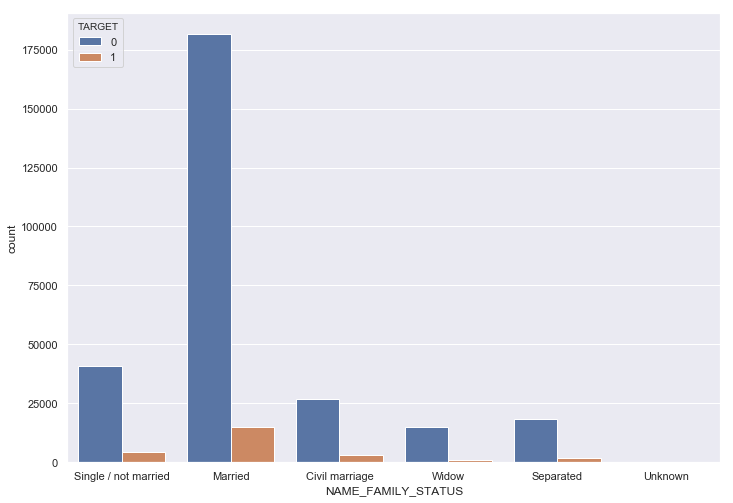

In [356]:
sns.countplot(x='NAME_FAMILY_STATUS', hue='TARGET', data=application_train)

##### NAME_HOUSING_TYPE
What is the housing situation of the client (renting, living with parents, ...)

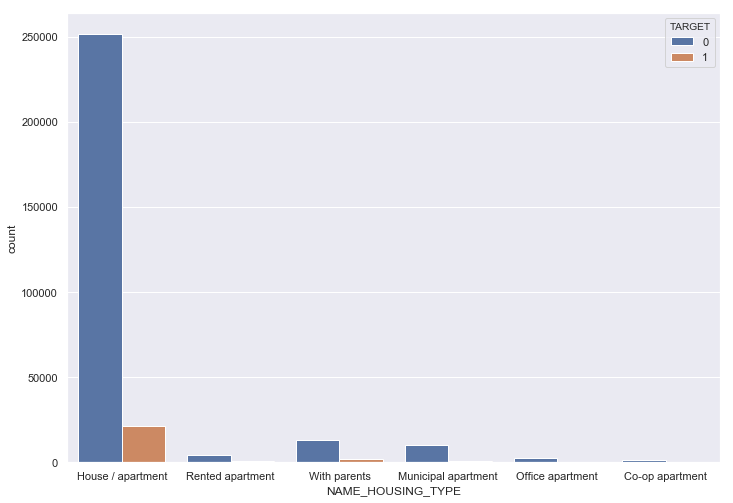

In [357]:
sns.countplot(x='NAME_HOUSING_TYPE', hue='TARGET', data=application_train)

##### OCCUPATION_TYPE
What kind of occupation does the client have

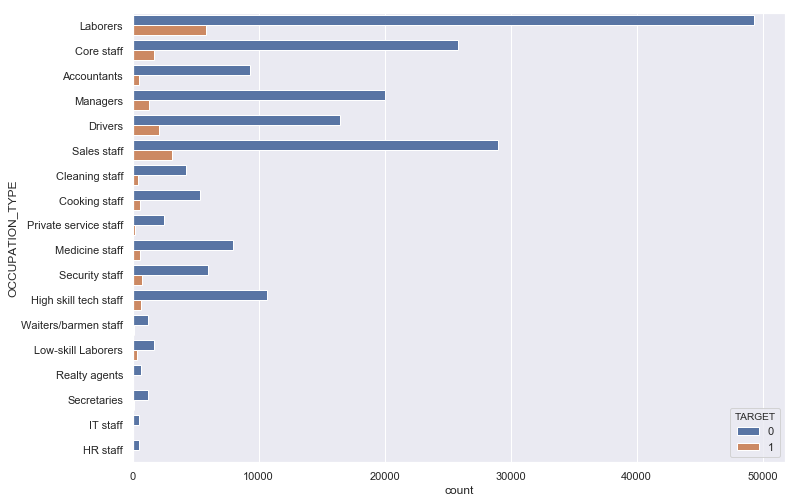

In [358]:
sns.countplot(y='OCCUPATION_TYPE', hue='TARGET', data=application_train)

##### WEEKDAY_APPR_PROCESS_START
On which day of the week did the client apply for the loan

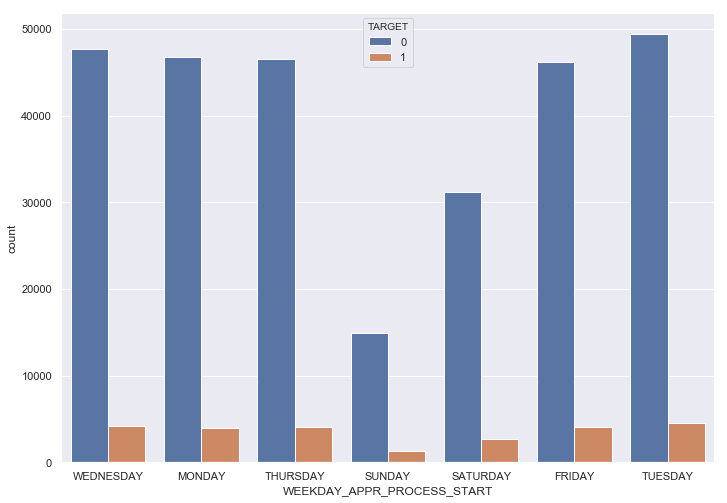

In [359]:
sns.countplot(x='WEEKDAY_APPR_PROCESS_START', hue='TARGET', data=application_train)

##### ORGANIZATION_TYPE
Type of organization where client works

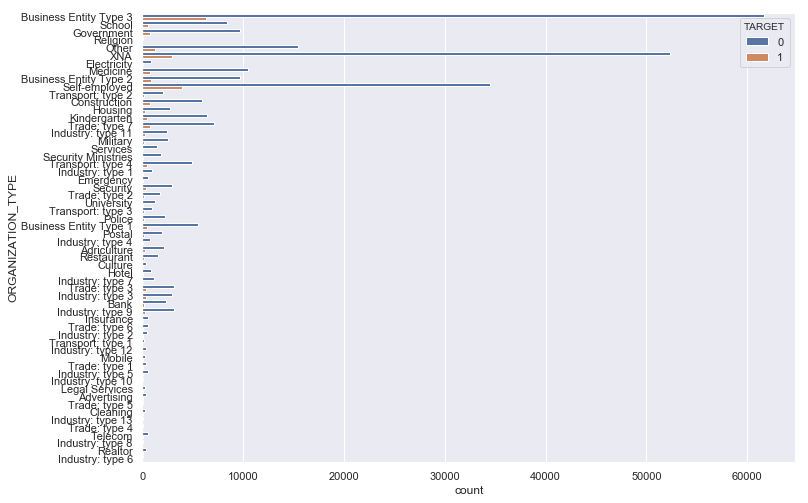

In [360]:
sns.countplot(y='ORGANIZATION_TYPE', hue='TARGET', data=application_train)

#### Numerical features
In this section, we will explore the numerical features 

##### AMT_INCOME_TOTAL
Income of the client

**Income distribution for the 0-800K range**

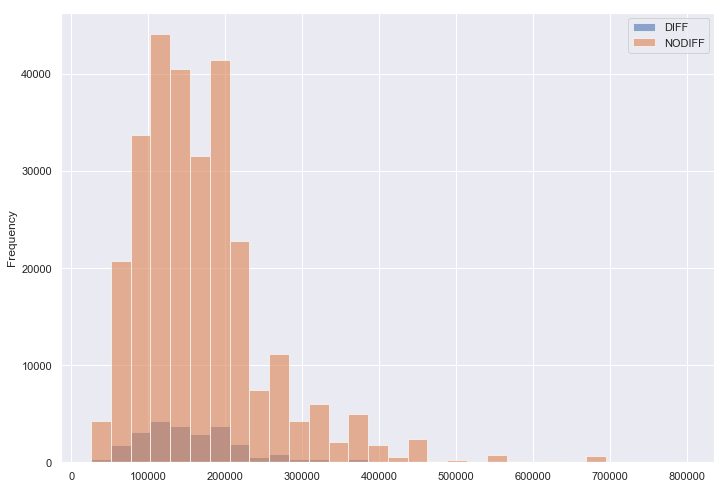

In [361]:
diff_AMT_INCOME_TOTAL = (application_train[application_train.TARGET == 1].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL < 800000)])
nodiff_AMT_INCOME_TOTAL = (application_train[application_train.TARGET == 0].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL < 800000)])

pd.DataFrame(
{'DIFF': diff_AMT_INCOME_TOTAL,
 'NODIFF': nodiff_AMT_INCOME_TOTAL},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 30,alpha=0.6)
plt.show()

**Income distribution for the 800K-2M range**

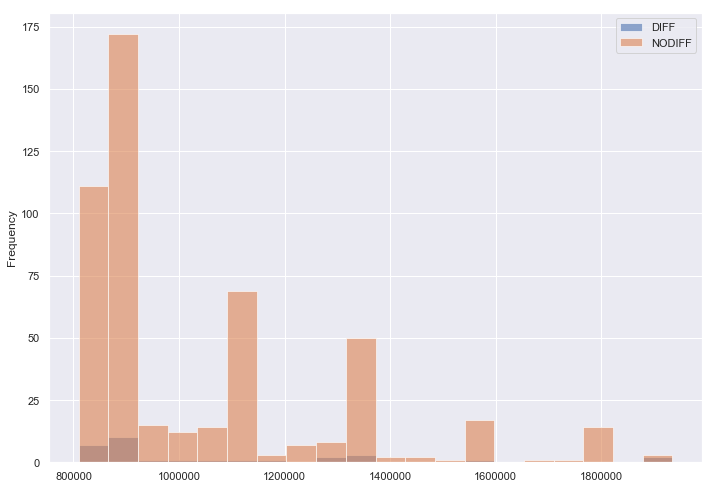

In [362]:
pd.DataFrame(
{'DIFF': application_train[application_train.TARGET == 1].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 800000) & (application_train.AMT_INCOME_TOTAL < 2000000)],
 'NODIFF': application_train[application_train.TARGET == 0].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 800000) & (application_train.AMT_INCOME_TOTAL < 2000000)]},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

**Income distribution for the 2M+ range**

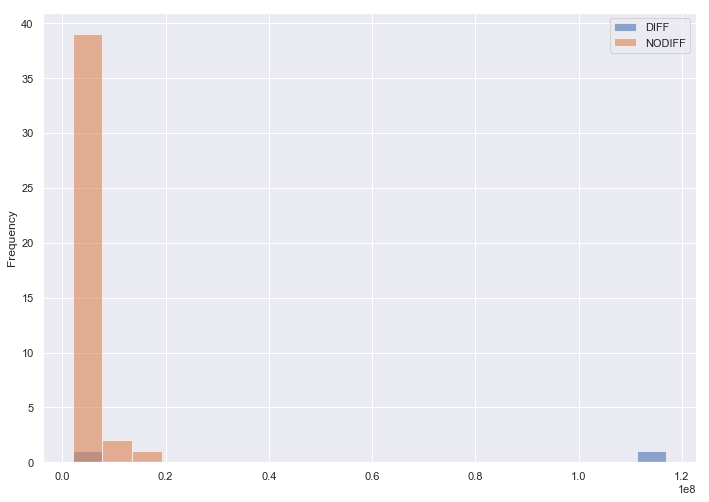

In [363]:
pd.DataFrame(
{'DIFF': application_train[application_train.TARGET == 1].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 2000000)],
 'NODIFF': application_train[application_train.TARGET == 0].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 2000000)]},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

#### AMT_CREDIT
Credit amount of the loan

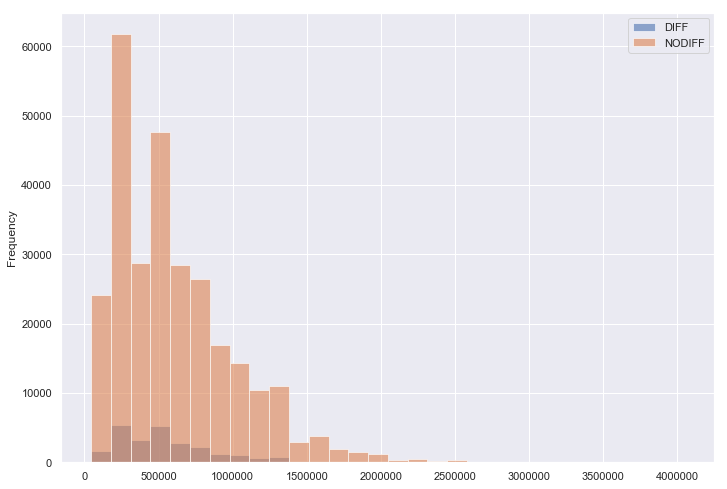

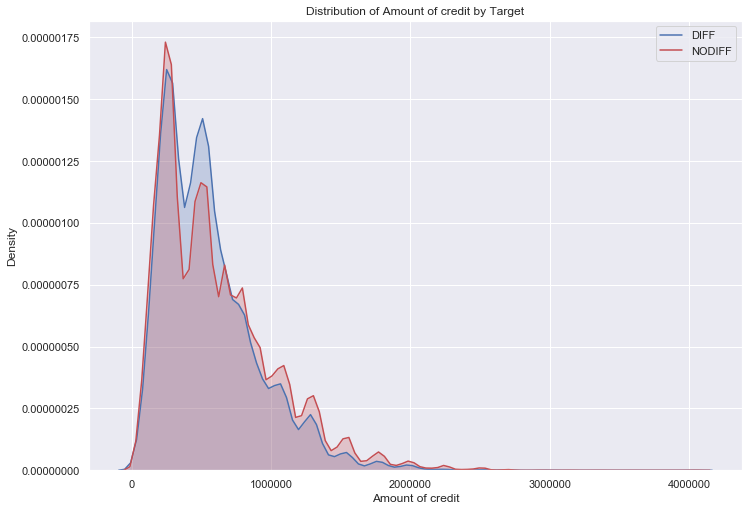

In [368]:
diff_AMT_CREDIT = application_train[(application_train.TARGET == 1) & (application_train.AMT_CREDIT.notnull())].AMT_CREDIT
nodiff_AMT_CREDIT = application_train[(application_train.TARGET == 0) & (application_train.AMT_CREDIT.notnull())].AMT_CREDIT

pd.DataFrame(
{'DIFF': diff_AMT_CREDIT,
 'NODIFF': nodiff_AMT_CREDIT},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 30,alpha=0.6)
plt.show()


plt.subplot(1, 1, 1)
sns.kdeplot(diff_AMT_CREDIT,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_AMT_CREDIT, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of Amount of credit by Target')
plt.xlabel('Amount of credit'); 
plt.ylabel('Density');

#### DAYS_BIRTH
Client's age in days at the time of application

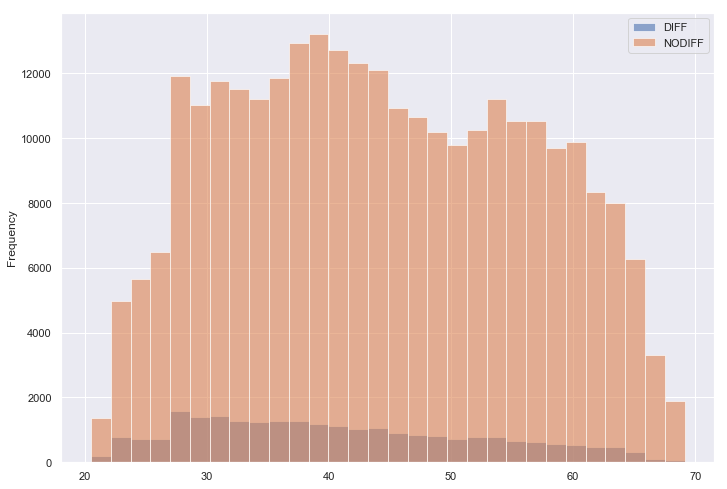

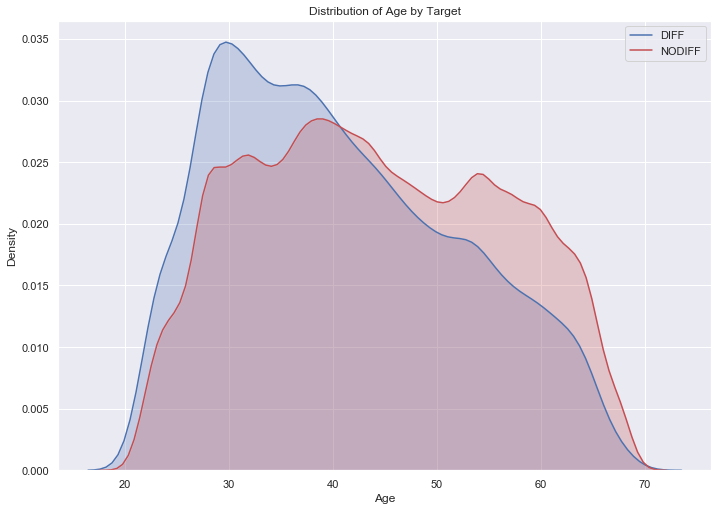

In [365]:
diff_DAYS_BIRTH = (application_train[application_train.TARGET == 1].DAYS_BIRTH/-365)
nodiff_DAYS_BIRTH = (application_train[application_train.TARGET == 0].DAYS_BIRTH/-365)

pd.DataFrame(
{'DIFF': diff_DAYS_BIRTH,
 'NODIFF': nodiff_DAYS_BIRTH},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 30,alpha=0.6)
plt.show()


plt.subplot(1, 1, 1)
sns.kdeplot(diff_DAYS_BIRTH,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_DAYS_BIRTH, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of Age by Target')
plt.xlabel('Age'); 
plt.ylabel('Density');

Younger people relatively have more difficulties

#### DAYS_EMPLOYED
How many days before the application the person started current employment

<function matplotlib.pyplot.show>

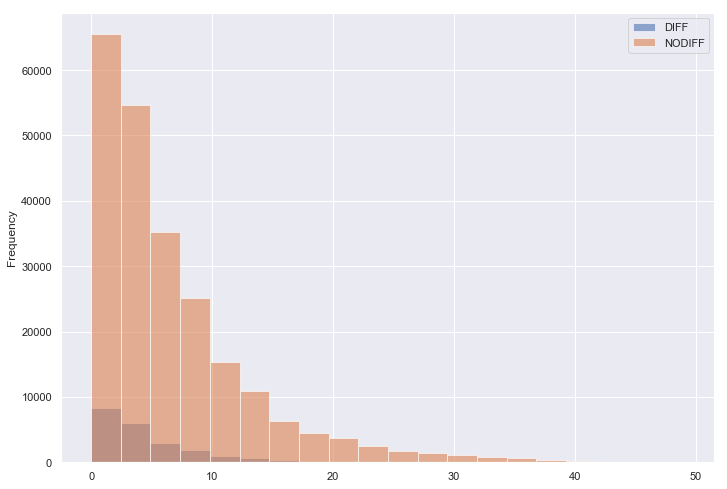

In [315]:
diff_DAYS_EMPLOYED = application_train[(application_train.TARGET == 1) & (application_train.DAYS_EMPLOYED.notnull())].DAYS_EMPLOYED/-365
nodiff_DAYS_EMPLOYED = application_train[(application_train.TARGET == 0) & (application_train.DAYS_EMPLOYED.notnull())].DAYS_EMPLOYED/-365

pd.DataFrame(
{'DIFF': diff_DAYS_EMPLOYED,
 'NODIFF': nodiff_DAYS_EMPLOYED},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

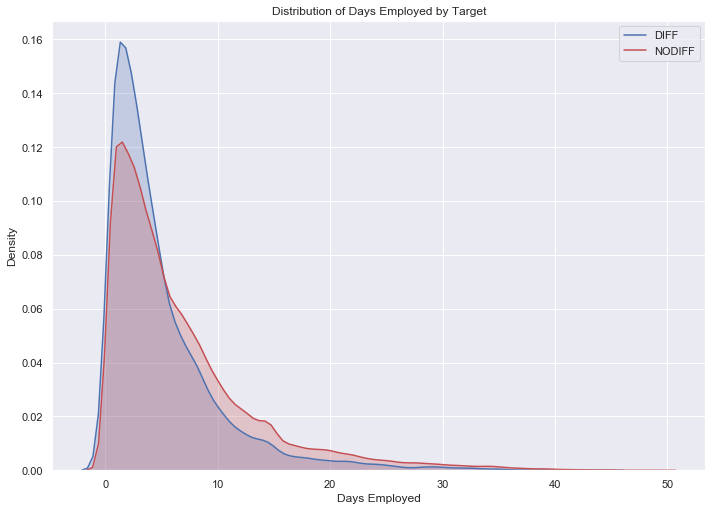

In [246]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_DAYS_EMPLOYED,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_DAYS_EMPLOYED, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of Days Employed by Target')
plt.xlabel('Days Employed'); 
plt.ylabel('Density');

 #### EXT_SOURCE_{2|3}
 Normalized score from external data source

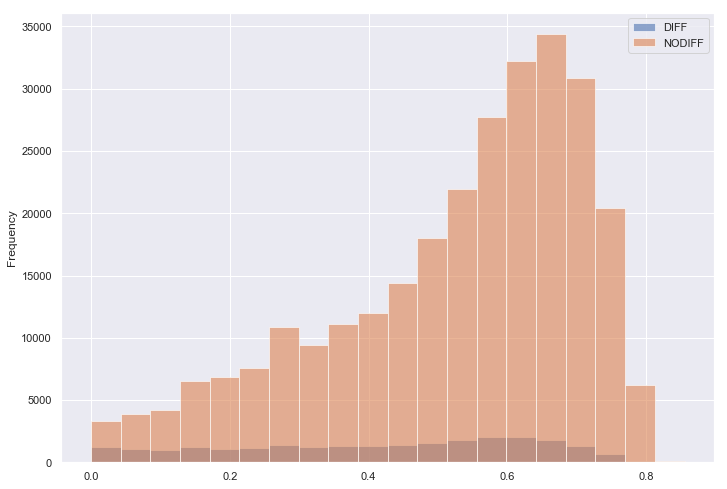

In [247]:
diff_EXT_SOURCE_2 = application_train[(application_train.TARGET == 1) & (application_train.EXT_SOURCE_2.notnull())].EXT_SOURCE_2
nodiff_EXT_SOURCE_2 = application_train[(application_train.TARGET == 0) & (application_train.EXT_SOURCE_2.notnull())].EXT_SOURCE_2


pd.DataFrame(
{'DIFF': diff_EXT_SOURCE_2
,
 'NODIFF': nodiff_EXT_SOURCE_2
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

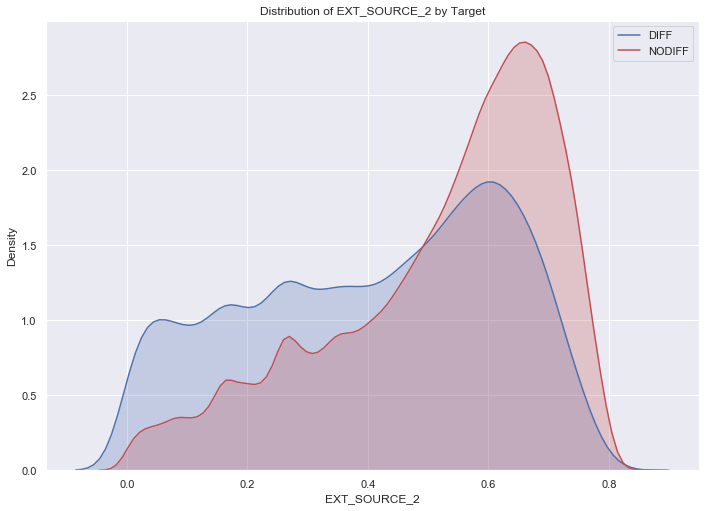

In [248]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCE_2,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCE_2, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCE_2 by Target')
plt.xlabel('EXT_SOURCE_2'); 
plt.ylabel('Density');

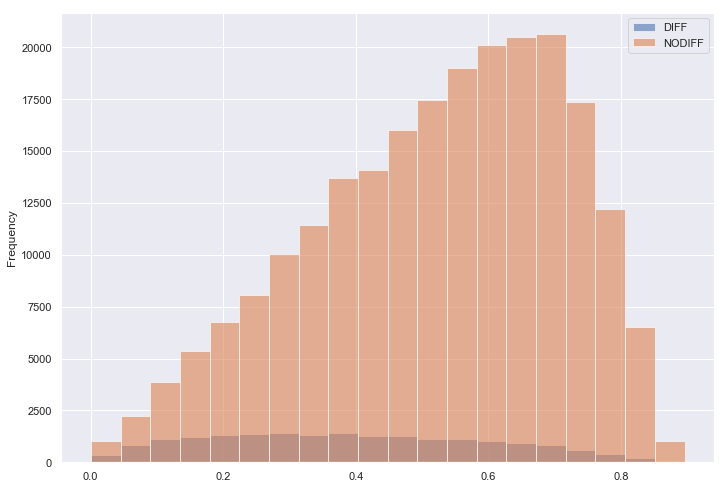

In [329]:
diff_EXT_SOURCE_3 = application_train[(application_train.TARGET == 1) & (application_train.EXT_SOURCE_3.notnull())].EXT_SOURCE_3
nodiff_EXT_SOURCE_3 = application_train[(application_train.TARGET == 0) & (application_train.EXT_SOURCE_3.notnull())].EXT_SOURCE_3
pd.DataFrame(
{'DIFF': diff_EXT_SOURCE_3
,
 'NODIFF': nodiff_EXT_SOURCE_3
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

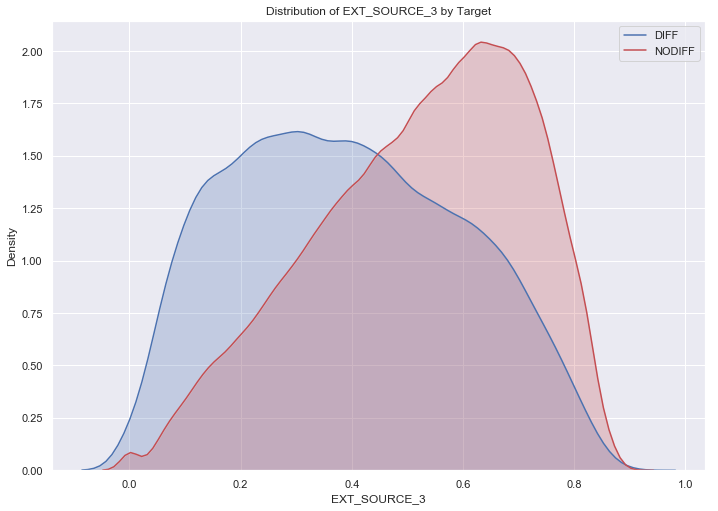

In [330]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCE_3,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCE_3, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCE_3 by Target')
plt.xlabel('EXT_SOURCE_3'); 
plt.ylabel('Density');

Lower scores have more difficulties and vice versa.

### Data preprocessing
In this part, we will process our data (encode the categorical features, bin continuous features, deal with nulls.. etc)
We will focus on the following features: 
CNT_CHILDREN,
AMT_INCOME_TOTAL,
AMT_CREDIT,
AMT_ANNUITY,
DAYS_BIRTH,
DAYS_EMPLOYED,
CNT_FAM_MEMBERS,
EXT_SOURCE_2,
EXT_SOURCE_3,
DAYS_LAST_PHONE_CHANGE,
REGION_RATING_CLIENT,
REGION_RATING_CLIENT_W_CITY,
REG_REGION_NOT_LIVE_REGION,
REG_REGION_NOT_WORK_REGION,
LIVE_REGION_NOT_WORK_REGION,
REG_CITY_NOT_LIVE_CITY,
REG_CITY_NOT_WORK_CITY,
LIVE_CITY_NOT_WORK_CITY,
NAME_CONTRACT_TYPE,
CODE_GENDER,
FLAG_OWN_CAR,
FLAG_OWN_REALTY,
NAME_TYPE_SUITE,
NAME_INCOME_TYPE,
NAME_EDUCATION_TYPE,
NAME_FAMILY_STATUS,
NAME_HOUSING_TYPE,
OCCUPATION_TYPE,
ORGANIZATION_TYPE

In [382]:
application_train_proc = application_train[['SK_ID_CURR','TARGET','CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']]

In [383]:
application_train_proc.loc[:,'CNT_CHILDREN'] = pd.cut(application_train_proc['CNT_CHILDREN'], bins=8,labels=False).replace(np.nan,8.0).astype(int)
application_train_proc.loc[:,'AMT_INCOME_TOTAL'] = pd.cut(application_train_proc['AMT_INCOME_TOTAL'], bins=15,labels=False).replace(np.nan,15.0).astype(int)
application_train_proc.loc[:,'AMT_ANNUITY'] = pd.cut(application_train_proc['AMT_ANNUITY'], bins=15,labels=False).replace(np.nan,15.0).astype(int)
application_train_proc.loc[:,'AMT_CREDIT'] = pd.cut(application_train_proc['AMT_CREDIT'], bins=15,labels=False).replace(np.nan,15.0).astype(int)
application_train_proc.loc[:,'DAYS_BIRTH'] = pd.cut(application_train_proc['DAYS_BIRTH'], bins=20,labels=False).replace(np.nan,20.0).astype(int)
application_train_proc.loc[:,'DAYS_EMPLOYED'] = pd.cut(application_train_proc['DAYS_EMPLOYED'], bins=10,labels=False).replace(np.nan,10.0).astype(int)
application_train_proc.loc[:,'CNT_FAM_MEMBERS'] = pd.cut(application_train_proc['CNT_FAM_MEMBERS'], bins=5,labels=False).replace(np.nan,0.0).astype(int)
application_train_proc.loc[:,'EXT_SOURCE_2'] = pd.cut(application_train_proc['EXT_SOURCE_2'], bins=20,labels=False).replace(np.nan,20.0).astype(int)
application_train_proc.loc[:,'EXT_SOURCE_3'] = pd.cut(application_train_proc['EXT_SOURCE_3'], bins=20,labels=False).replace(np.nan,20.0).astype(int)
application_train_proc.loc[:,'DAYS_LAST_PHONE_CHANGE'] = pd.cut(application_train_proc['DAYS_LAST_PHONE_CHANGE'], bins=15,labels=False).replace(np.nan,15.0).astype(int)
application_train_proc.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,100002,1,0,0,1,1,17,9,0,6,3,11,2,2,0,0,0,0,0,0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,Business Entity Type 3
1,100003,0,0,0,4,1,9,9,0,14,20,12,1,1,0,0,0,0,0,0,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,School
2,100004,0,0,0,0,0,6,9,0,13,16,12,2,2,0,0,0,0,0,0,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,Government
3,100006,0,0,0,1,1,7,8,0,15,20,12,2,2,0,0,0,0,0,0,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,Business Entity Type 3
4,100007,0,0,0,1,1,5,8,0,7,20,11,2,2,0,0,0,0,1,1,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,Religion


In [280]:
pd.get_dummies(application_train, dummy_na=True).columns

Index([u'SK_ID_CURR', u'TARGET', u'CNT_CHILDREN', u'AMT_INCOME_TOTAL',
       u'AMT_CREDIT', u'AMT_ANNUITY', u'AMT_GOODS_PRICE',
       u'REGION_POPULATION_RELATIVE', u'DAYS_BIRTH', u'DAYS_EMPLOYED',
       ...
       u'ORGANIZATION_TYPE_Trade: type 5', u'ORGANIZATION_TYPE_Trade: type 6',
       u'ORGANIZATION_TYPE_Trade: type 7',
       u'ORGANIZATION_TYPE_Transport: type 1',
       u'ORGANIZATION_TYPE_Transport: type 2',
       u'ORGANIZATION_TYPE_Transport: type 3',
       u'ORGANIZATION_TYPE_Transport: type 4', u'ORGANIZATION_TYPE_University',
       u'ORGANIZATION_TYPE_XNA', u'ORGANIZATION_TYPE_nan'],
      dtype='object', length=196)

In [287]:
len(application_train.columns)

73

In [59]:
application_train.select_dtypes(['int','float']).columns.drop(['TARGET','SK_ID_CURR']).tolist()

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13'

In [291]:
application_train.select_dtypes(['object']).columns.tolist()

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

In [301]:
pd.cut(application_train['DAYS_EMPLOYED'], bins=10,labels=False).replace(np.nan,10.0)


0          9.0
1          9.0
2          9.0
3          8.0
4          8.0
5          9.0
6          8.0
7          9.0
8         10.0
9          8.0
10         9.0
11        10.0
12         8.0
13         8.0
14         9.0
15         9.0
16         9.0
17         9.0
18         5.0
19         8.0
20         7.0
21         9.0
22         7.0
23        10.0
24         9.0
25         8.0
26         8.0
27         9.0
28         8.0
29         9.0
          ... 
307481     8.0
307482     9.0
307483    10.0
307484     9.0
307485     9.0
307486     9.0
307487    10.0
307488     9.0
307489     9.0
307490     8.0
307491     8.0
307492     9.0
307493     8.0
307494     6.0
307495     5.0
307496     8.0
307497     9.0
307498     7.0
307499     5.0
307500     7.0
307501     9.0
307502     5.0
307503     9.0
307504     5.0
307505    10.0
307506     9.0
307507    10.0
307508     5.0
307509     7.0
307510     9.0
Name: DAYS_EMPLOYED, Length: 307511, dtype: float64

In [314]:
application_train['EXT_SOURCE_2'].isnull().sum()

660